In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp
from pathlib import Path
from tqdm import tqdm
import torch.nn.functional as F
import re

In [2]:
full_train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_filenames = (list(full_train_df['id']) + list(test_df['id']))
len(all_filenames)

35000

In [3]:
dev_flag = True
data_dir = 'data/melspec_nfft512_nc64'

# text and tokens

In [4]:
# $ - start; % - end
index_to_token = ['$', '%'] + sorted(set(''.join(full_train_df['message'])))
start_token = index_to_token[0]
end_token = index_to_token[1]
print(f'st = {start_token}; et = {end_token}')
token_to_index = dict([(token, i) for i, token in enumerate(index_to_token)])
dictionary_size = len(index_to_token)
print(dictionary_size)
print(index_to_token)
print(token_to_index)

st = $; et = %
46
['$', '%', ' ', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
{'$': 0, '%': 1, ' ': 2, '#': 3, '0': 4, '1': 5, '2': 6, '3': 7, '4': 8, '5': 9, '6': 10, '7': 11, '8': 12, '9': 13, 'А': 14, 'Б': 15, 'В': 16, 'Г': 17, 'Д': 18, 'Е': 19, 'Ж': 20, 'З': 21, 'И': 22, 'Й': 23, 'К': 24, 'Л': 25, 'М': 26, 'Н': 27, 'О': 28, 'П': 29, 'Р': 30, 'С': 31, 'Т': 32, 'У': 33, 'Ф': 34, 'Х': 35, 'Ц': 36, 'Ч': 37, 'Ш': 38, 'Щ': 39, 'Ъ': 40, 'Ы': 41, 'Ь': 42, 'Э': 43, 'Ю': 44, 'Я': 45}


In [5]:
class Vectorizer:
    def __init__(self):
        self.text_to_nums = token_to_index
        self.nums_to_text = index_to_token
        pass

    def to_tensor(self, text: str):
        return torch.tensor([self.text_to_nums[ch] for ch in text])
    
    def from_tensor(self, tensor: torch.Tensor):
        assert tensor.ndim == 1
        return ''.join([self.nums_to_text[num.item()] for num in tensor])

vec_maker = Vectorizer()

def text_transform(text: str):
    return vec_maker.to_tensor(text)

def batch_text_transform(texts: list[str], pad_value = 1):
    vecs = []
    for t in texts:
        vecs.append(text_transform(t))
    lengths = torch.tensor([len(v) for v in vecs])
    desired_length = torch.max(lengths)
    vecs = [F.pad(v, (0, desired_length - len(v)), value=pad_value) for v in vecs]
    batch = torch.stack(vecs, dim=0)
    return batch, lengths

## data

In [6]:
class ListDataset(torch.utils.data.Dataset):
    def __init__(self, features: list, labels: list, transform = lambda x: x):
        self.features = features
        self.labels = labels
        assert len(features) == len(labels)
        self.transform = transform
        pass

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.transform(self.features[index]), self.labels[index]

In [7]:
rng = np.random.default_rng()

def rotation_transform(tensor: torch.Tensor):
    threshold = rng.integers(0, tensor.shape[0])
    result = torch.concat([tensor[threshold:], tensor[:threshold]], dim=0)
    return result

In [8]:
def load_tensors(dir_path, filenames):
    for name in filenames:
        path = Path(dir_path, name)
        yield torch.load(path, weights_only=True)

In [9]:
def filenames_to_torch(filenames):
    for name in filenames:
        yield Path(name).with_suffix('.pt')

def add_special_tokens(texts: str):
    for text in texts:
        yield start_token + text + end_token

(3000,) (5000,)


3000it [00:03, 815.66it/s]
5000it [00:05, 962.11it/s] 


3000 5000
$МЪА П0ЪЛ%


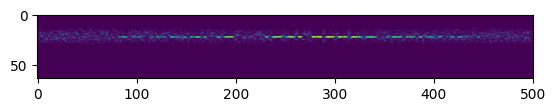

In [10]:
from sklearn.model_selection import train_test_split
train_index, val_index = train_test_split(np.arange(full_train_df.shape[0]), test_size=1/6, shuffle=True, 
                                           random_state=42)
if dev_flag:
    train_index = train_index[:3000]    # to save memory

print(train_index.shape, val_index.shape)

train_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(full_train_df.iloc[train_index]['id'])))))
val_features = list(tqdm(load_tensors(data_dir, filenames_to_torch(list(full_train_df.iloc[val_index]['id'])))))
train_labels = list(add_special_tokens(full_train_df.iloc[train_index]['message']))
val_labels = list(add_special_tokens(full_train_df.iloc[val_index]['message']))

assert len(train_features) == len(train_labels)
assert len(val_features) == len(val_labels)

trainset = ListDataset(train_features, train_labels, transform=rotation_transform)
valset = ListDataset(val_features, val_labels)

print(len(trainset), len(valset))
plt.imshow(valset[0][0])
print(valset[0][1])

In [11]:
batch_text_transform(val_labels[:10])

(tensor([[ 0, 26, 40, 14,  2, 29,  4, 40, 25,  1,  1,  1,  1,  1,  1],
         [ 0, 27,  9,  3, 20,  6, 31, 12, 24, 17,  1,  1,  1,  1,  1],
         [ 0, 26, 42,  4, 44, 42,  2, 38, 37, 25, 27,  1,  1,  1,  1],
         [ 0, 28, 17,  5,  2, 25, 19, 19, 15, 35, 22, 19, 39,  1,  1],
         [ 0,  7, 20, 29,  6, 29, 22,  9, 41,  1,  1,  1,  1,  1,  1],
         [ 0, 34,  2, 35, 32, 15, 40,  3, 25, 32, 26, 22, 30, 29,  1],
         [ 0, 38,  8,  4, 37,  2, 41, 23, 16, 45, 17,  1,  1,  1,  1],
         [ 0, 13,  2,  5, 16, 39, 35,  2, 40,  1,  1,  1,  1,  1,  1],
         [ 0, 30, 44,  2, 21,  2, 17, 42, 28,  2, 18, 36,  1,  1,  1],
         [ 0, 21,  2, 27, 19, 21, 31, 24, 14,  3, 27, 42, 33, 30,  1]]),
 tensor([10, 11, 12, 14, 10, 15, 12, 10, 13, 15]))

# model

In [12]:
# from here https://github.com/pytorch/examples/blob/main/word_language_model/model.py
import math


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)  # how about to cuda? might be handled by model.to('cuda') though

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

In [61]:
N = 5   # batch
S = 501
T = 30 
E = 64
tgt = torch.ones((T, N, E), dtype=torch.long)
memory = torch.ones((S, N, E))

torch.Size([30, 64])


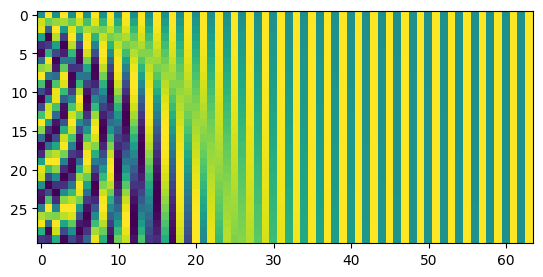

In [62]:
out = PositionalEncoding(d_model=E)(torch.zeros(T, N, E))
print(out[:, 0, :].shape)
plt.imshow(out[:, 0, :])

In [63]:
class TModel(nn.Module):
    def __init__(self, n_embeddings: int, inner_dim: int, out_size: int, num_layers:int = 4):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=n_embeddings, embedding_dim=inner_dim)
        self.tgt_pos_encoding = PositionalEncoding(d_model=inner_dim)
        self.memory_pos_encoding = PositionalEncoding(d_model=inner_dim)
        self.decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=inner_dim, nhead=8, dim_feedforward=128, dropout=0.1),
            num_layers=num_layers)
        self.head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(inner_dim, out_size),
            nn.LayerNorm(out_size),
        )
        pass

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))
    
    def forward(self, tgt: torch.Tensor, memory: torch.Tensor):
        x = self.embedding(tgt)
        x = self.tgt_pos_encoding(x)
        memory = self.memory_pos_encoding(memory)
        out = self.decoder(x, memory, tgt_mask=self._generate_square_subsequent_mask(tgt.shape[0]))   # todo: cache mask
        out = self.head(out)
        return out

In [64]:
class FullTransformer(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        pass

    def forward(self):
        raise ValueError('not implemented')

# train like

In [86]:
def cross_entropy_loss(x: torch.Tensor, gt: torch.Tensor, seq_lengths: torch.Tensor):
    probs = torch.softmax(x, dim=-1)
    indexes = torch.arange(probs.shape[0]).unsqueeze(1)
    mask = (indexes < seq_lengths)[:, :, None]
    true_probs = F.one_hot(gt, dictionary_size)
    token_loss = torch.sum(true_probs * torch.log(probs) * mask, dim=-1)
    loss = -torch.mean(token_loss)
    return loss

In [87]:
class ResBlock(nn.Module):
        def __init__(self, size, p_dropout):
            super().__init__()
            self.cell = nn.Sequential(
                nn.Conv1d(size, size, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(size),
                nn.Dropout(p=p_dropout),
                nn.Conv1d(size, size, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm1d(size),
                nn.Dropout(p=p_dropout),
            )
            self.activation = nn.ReLU()
            pass

        def forward(self, x):
            return self.activation(x + self.cell(x))
        pass


class MySomething(nn.Module):
    def __init__(self, n_pooled_blocks = 3, n_head_blocks = 2, pooled_blocks_thickness=1, input_size = 64, inner_size = 64, output_size = 5, p_dropout = 0.1):
        super().__init__()
        self.estimator = nn.Sequential(
            nn.Conv1d(input_size, inner_size, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm1d(inner_size),
            nn.Dropout(),
            *[
                 nn.Sequential(
                    *[ResBlock(inner_size, p_dropout) for i_ in range(pooled_blocks_thickness)],
                    nn.MaxPool1d(kernel_size=2, stride=2),
                    ) for _ in range(n_pooled_blocks)
            ],
            *[ResBlock(inner_size, p_dropout) for _ in range(n_head_blocks)],
            nn.Conv1d(inner_size, output_size, kernel_size=3),
        )
        pass

    def forward(self, x):
        return self.estimator(x)

In [88]:
class CNNSoundEncoder(nn.Module):
    def __init__(self, encoder: nn.Module):
        super().__init__()
        self.encoder = encoder
        pass

    def forward(self, x: torch.Tensor):
        assert x.ndim == 3
        encoded = self.encoder(x)
        encoded = encoded.transpose(0, 2).transpose(1, 2)
        return encoded

In [89]:
if dev_flag:
    raise ValueError("dev flag is up!")

ValueError: dev flag is up!

In [90]:
n_pooled_blocks = 4
n_head_blocks = 2
inner_size = 64
p_dropout = 0.165

sound_model = MySomething(n_pooled_blocks = n_pooled_blocks, n_head_blocks = n_head_blocks,
                    input_size = 64, inner_size = inner_size, output_size = 44 + 1,
                    p_dropout = p_dropout).to('cpu')
sound_model.load_state_dict(torch.load('models/cnn_ctc/best_params_retrained_30ep.pt', weights_only=True, map_location=torch.device('cpu')))

decoder_model = TModel(n_embeddings=dictionary_size, inner_dim=64, out_size=dictionary_size)
encoder_model = CNNSoundEncoder(sound_model.estimator[:-1])

model = FullTransformer(encoder_model, decoder_model)

In [113]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
val_loader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=True)

for epoch in range(5):
    loss_buffer = []
    for features, labels in tqdm(val_loader):
        encoded = model.encoder(features)
        targets, target_lengths = batch_text_transform(labels)
        targets = targets.transpose(0, 1)
        logits = model.decoder(targets, encoded)
        loss = cross_entropy_loss(logits[:1], targets[1:], target_lengths - 1)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_buffer.append(loss.detach())
    print(torch.mean(torch.tensor(loss_buffer)))

100%|██████████| 157/157 [00:19<00:00,  8.24it/s]


tensor(2.9152)


100%|██████████| 157/157 [00:19<00:00,  8.18it/s]


tensor(2.8972)


100%|██████████| 157/157 [00:18<00:00,  8.28it/s]


tensor(2.8868)


100%|██████████| 157/157 [00:18<00:00,  8.28it/s]


tensor(2.8883)


100%|██████████| 157/157 [00:19<00:00,  8.11it/s]

tensor(2.8746)


In [114]:
def greedy_sampling(transformer: FullTransformer, features: torch.Tensor, device, out_length = 20):
    with torch.no_grad():
        memory = transformer.encoder(features)
        decoder_input, _ = batch_text_transform([start_token] * memory.shape[1])
        decoder_input = decoder_input.transpose(0, 1).to(device)
        for i in range(1, out_length):
            logits = transformer.decoder(decoder_input, memory)
            preds = torch.argmax(logits[[-1]], dim=-1)
            next_input = torch.concat([decoder_input, preds], dim=0)
            decoder_input = next_input
        decoder_input = decoder_input.to('cpu')
        sampled_text = [vec_maker.from_tensor(decoder_input[:, i]) for i in range(decoder_input.shape[1])]
    return sampled_text

In [115]:
features, gt_labels = next(iter(val_loader))
greedy_sampling(transformer=model, features=features, device='cpu')[:10]

['$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%',
 '$%%%%%%%%%%%%%%%%%%%']

In [26]:
np.random.randint(0, 100)

54